View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/

My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:

- torch: 0.4
- torchvision
- matplotlib

In [2]:
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(1) # reproducible

# Hyper parameters
EPOCHE = 1           # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50      # 
LR = 0.001           # learning rate
DOWNLOAD_MNIST=False #

In [3]:
# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empty dir
    DOWNLOAD_MNIST = True
    
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                   # this is training data
    transform=torchvision.transforms.ToTensor(),  # Converts a PIL.Image or numpy.ndarray to
                                                  # torch.FloatTensor of shape(C x H x W) and normalize in
                                                  # the range [0.0, 1.0]
    download = DOWNLOAD_MNIST,

)

0it [00:00, ?it/s]

9920512it [00:01, 6913378.85it/s]                             


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 93361.75it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


1654784it [00:02, 632881.73it/s]                             
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


8192it [00:00, 35232.88it/s]            


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


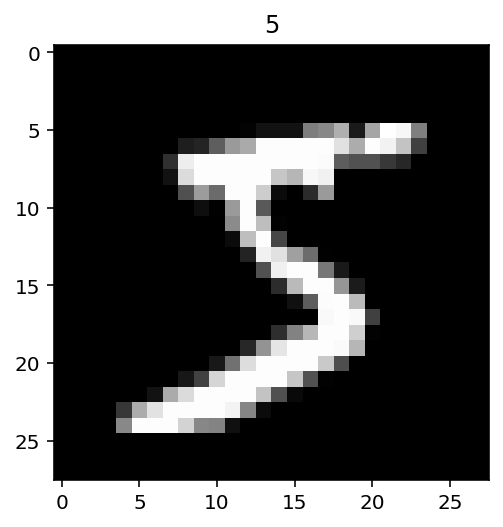

In [7]:
# train_data
# plot one example
print(train_data.train_data.size())   # (60000, 28, 28)
print(train_data.train_labels.size()) # (60000)

%config InlineBackend.figure_format ='retina'
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [9]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50,1,28,28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

# shape from (2000, 28, 28) to (2000, 1, 28, 28) [WHY??], value in range(0,1)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255  
test_y = test_data.test_labels[:2000]



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(      # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,           # input height(bands/ colors)
                out_channels=16,         # n_filters
                kernel_size=5,           # filter size (squre or (5,3) for ex. )
                stride=1,                # filter movement/step
                padding=2,               # if want some width and length of this image after Conv2d,
                                         #  padding = (kernel_size-1)/2 if stride=1     
            ),
            nn.ReLU(),                   # activation
            nn.MaxPool2d(kernel_size=2), # choose max value in 2x2 area, output shape(16, 14, 14)            
        )
        self.conv2 = nn.Sequential(      # input shape(16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape(32,14, 14)
            nn.ReLU(),                   # activation
            nn.MaxPool2d(2),             # output shape(32, 7, 7) 
        )
        self.out = nn.Linear(32 * 7 * 7, 10) # fully connected layer, output 10 classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)        # flatten the output fo conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x  # return x for visualization
    
cnn = CNN()
print(cnn) # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                      # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK=True
except: HAS_SK=False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.clf() # plt.cla() if .py code
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255*s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show()
    plt.pause(0.01)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Epoch:  0 | train loss: 2.2908 | test accuracy: 0.24


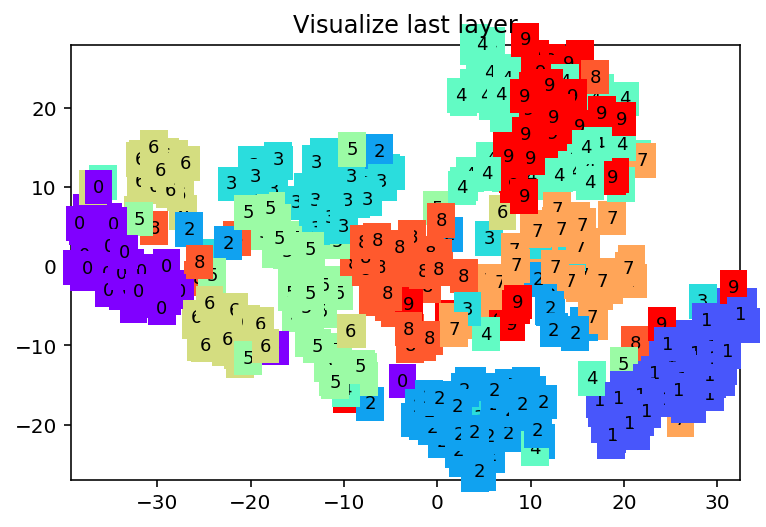

Epoch:  0 | train loss: 0.4422 | test accuracy: 0.80


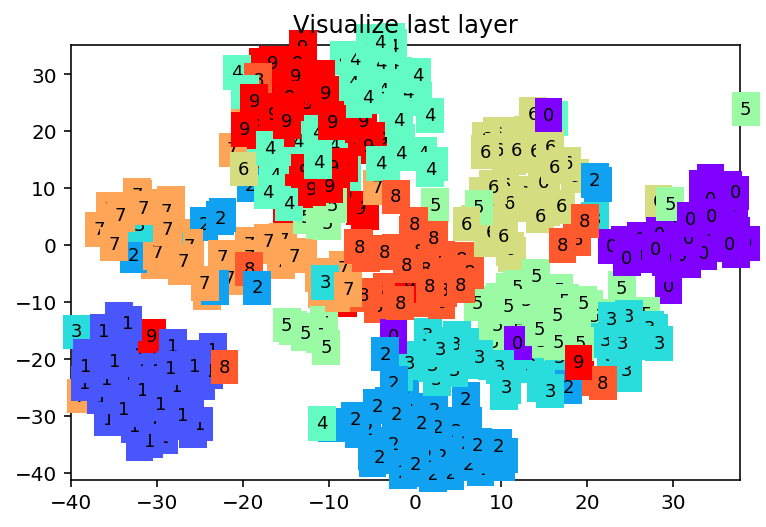

Epoch:  0 | train loss: 0.1702 | test accuracy: 0.89


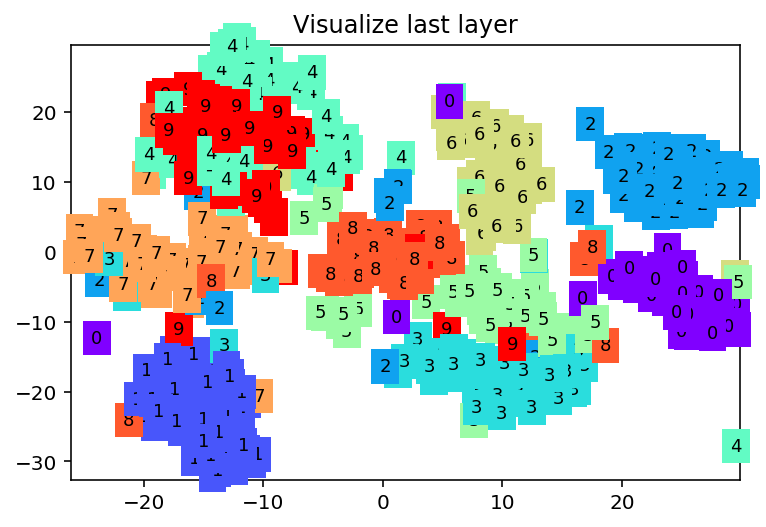

Epoch:  0 | train loss: 0.3275 | test accuracy: 0.90


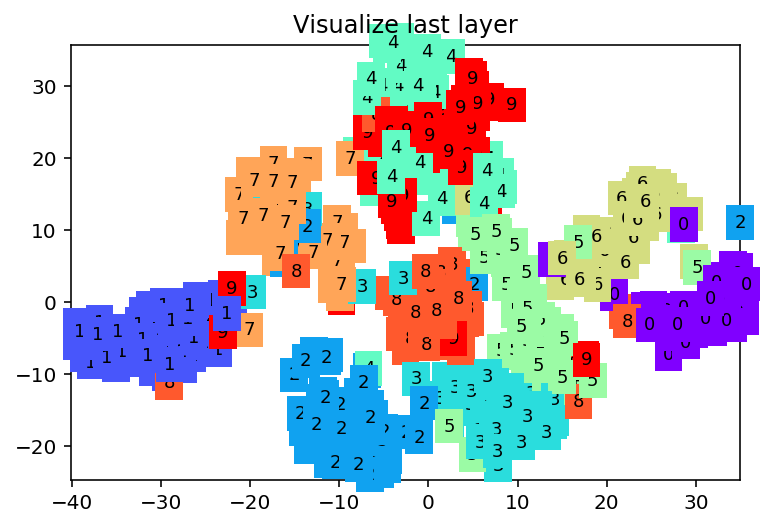

Epoch:  0 | train loss: 0.4606 | test accuracy: 0.93


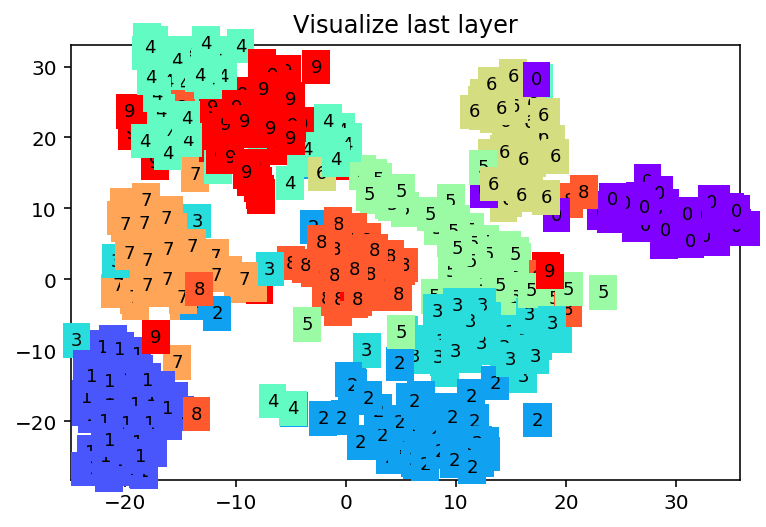

Epoch:  0 | train loss: 0.1532 | test accuracy: 0.94


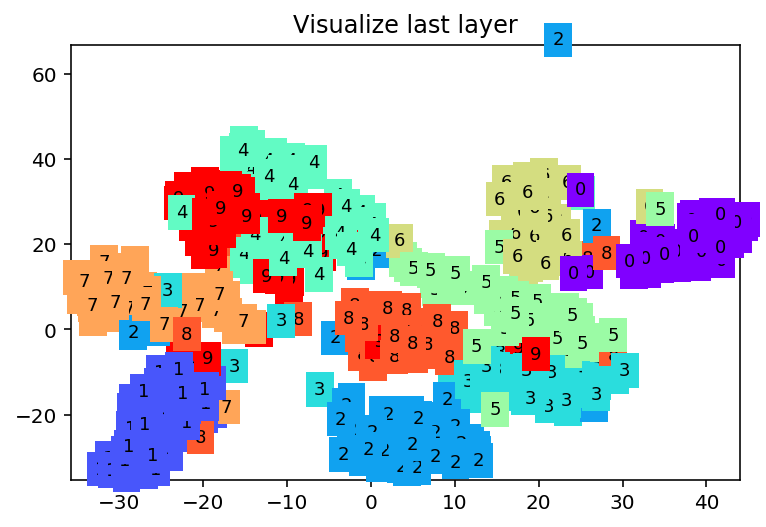

Epoch:  0 | train loss: 0.1845 | test accuracy: 0.95


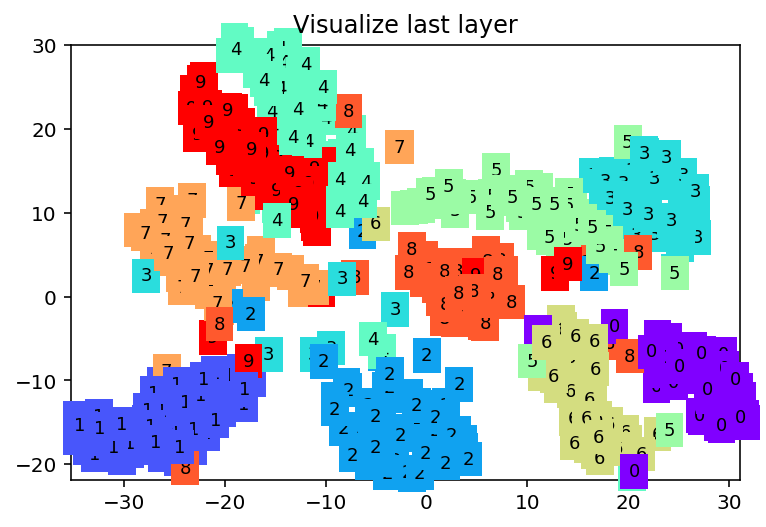

Epoch:  0 | train loss: 0.1632 | test accuracy: 0.95


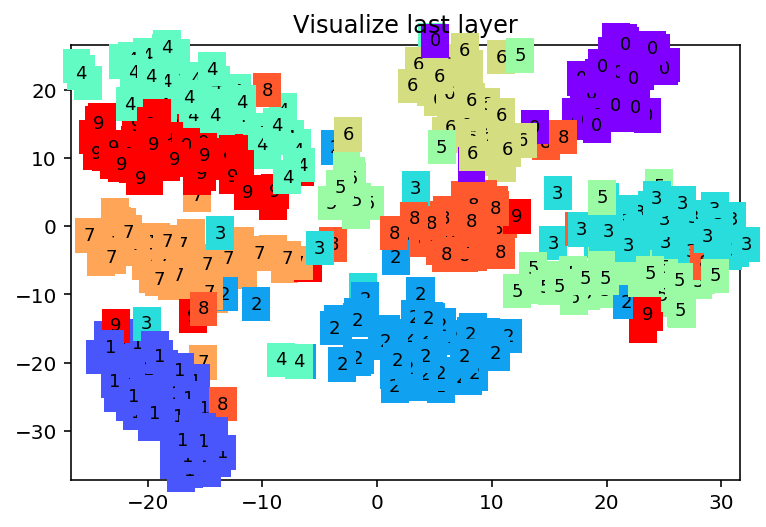

Epoch:  0 | train loss: 0.0718 | test accuracy: 0.96


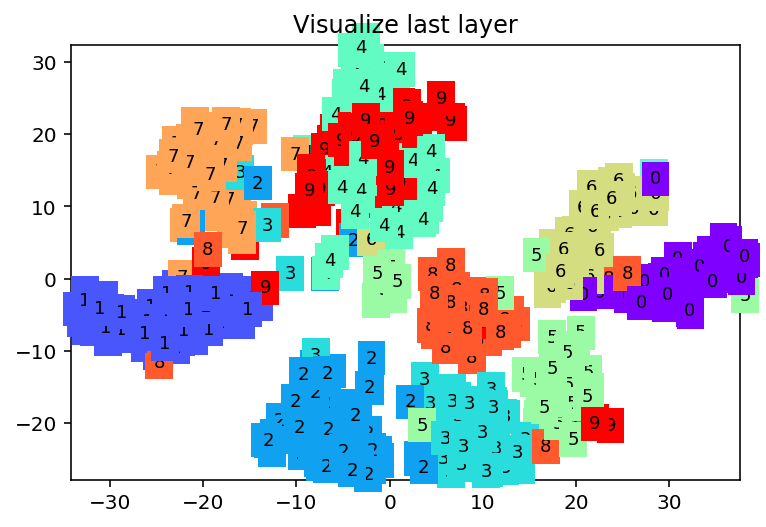

Epoch:  0 | train loss: 0.0391 | test accuracy: 0.96


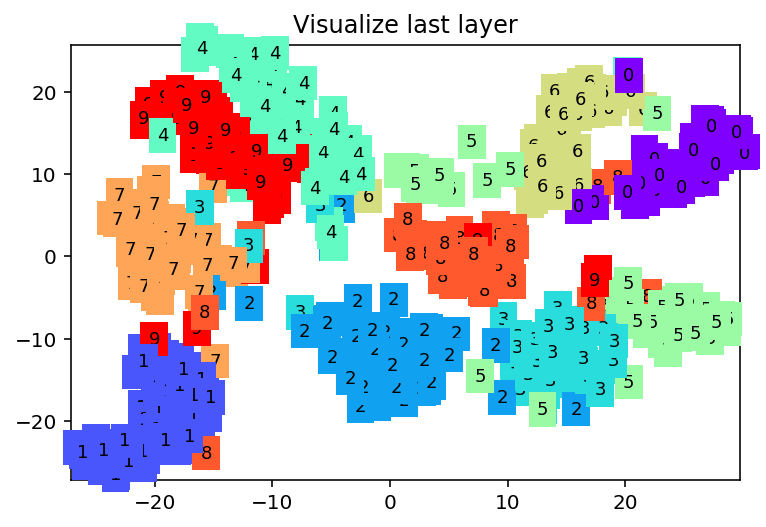

Epoch:  0 | train loss: 0.0207 | test accuracy: 0.95


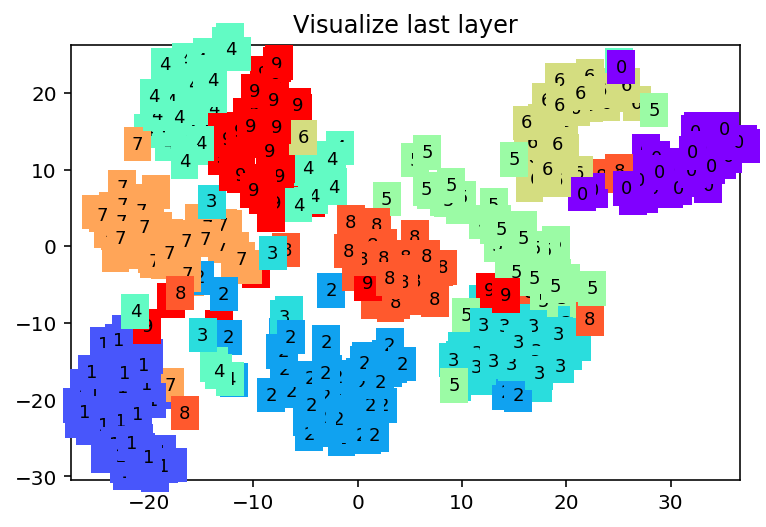

Epoch:  0 | train loss: 0.0177 | test accuracy: 0.97


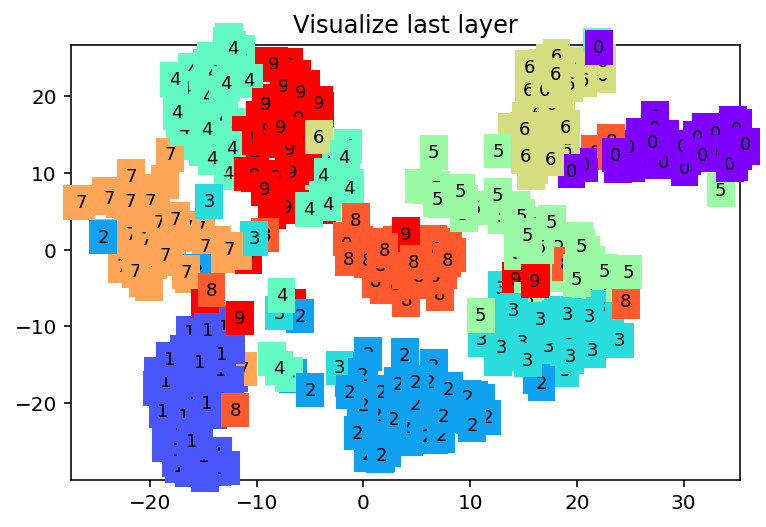

Epoch:  0 | train loss: 0.3752 | test accuracy: 0.96


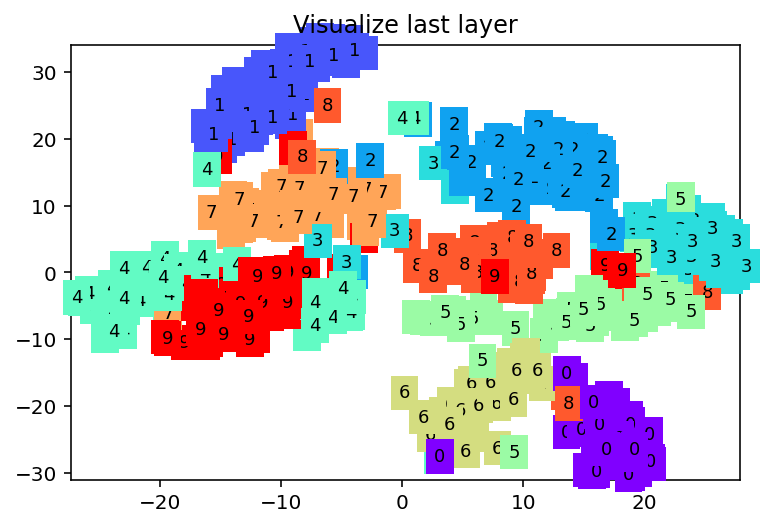

Epoch:  0 | train loss: 0.0952 | test accuracy: 0.97


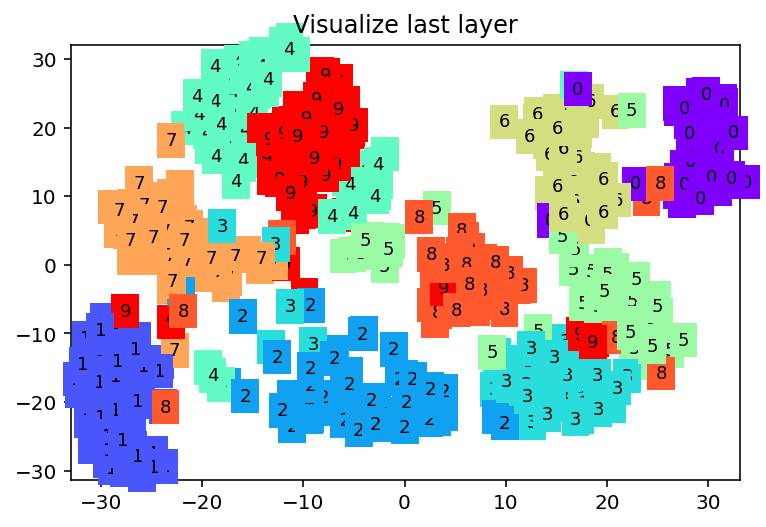

Epoch:  0 | train loss: 0.0632 | test accuracy: 0.98


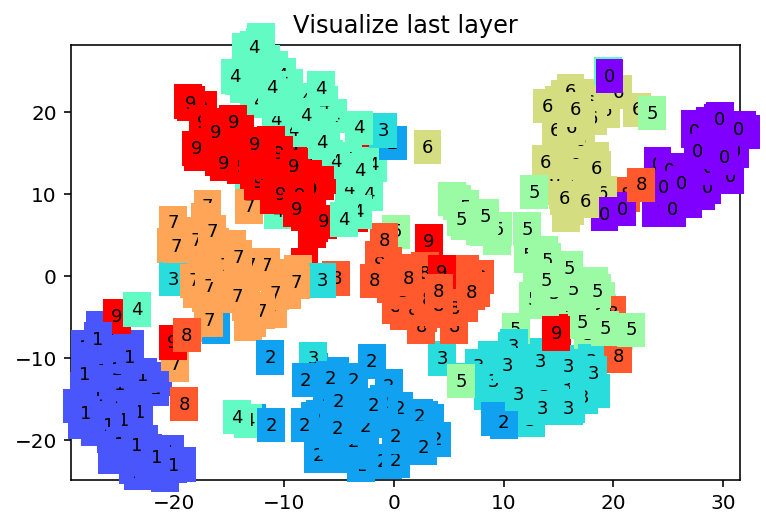

Epoch:  0 | train loss: 0.0584 | test accuracy: 0.97


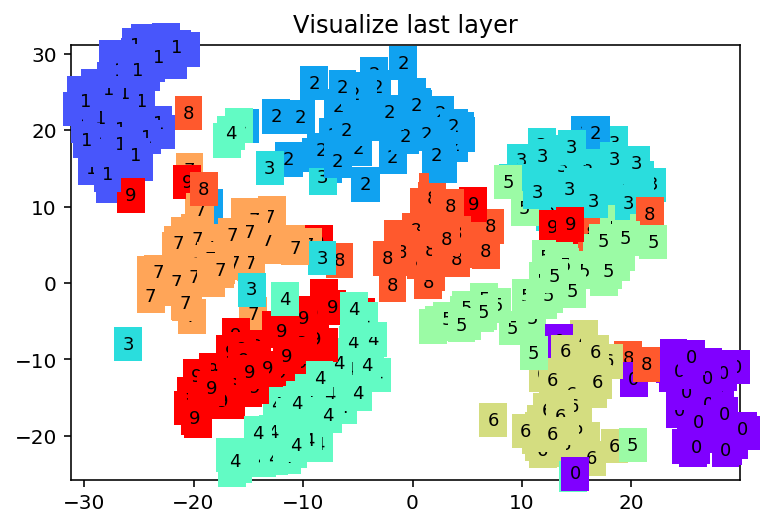

Epoch:  0 | train loss: 0.0391 | test accuracy: 0.97


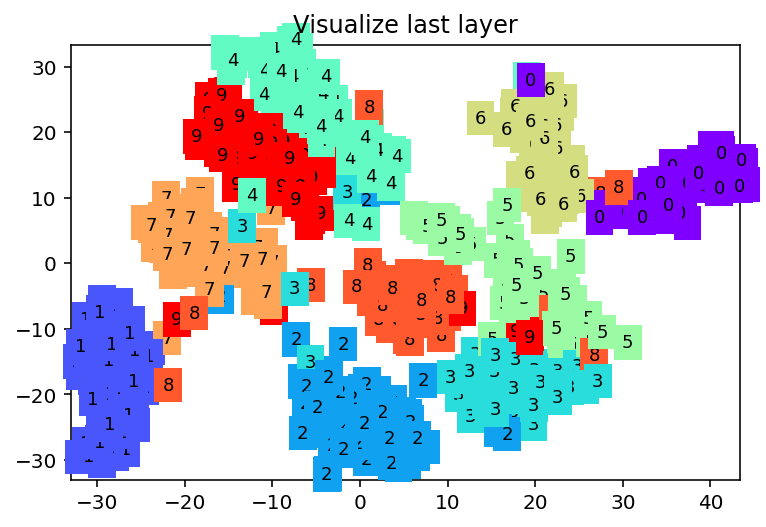

Epoch:  0 | train loss: 0.0403 | test accuracy: 0.97


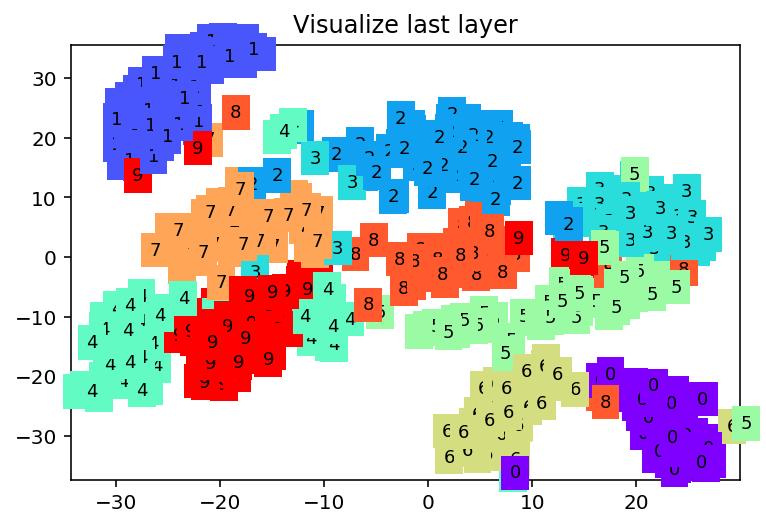

Epoch:  0 | train loss: 0.0149 | test accuracy: 0.97


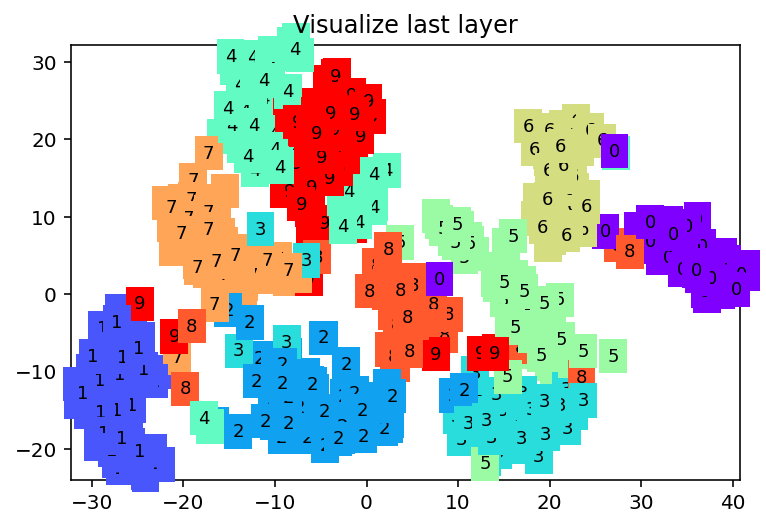

Epoch:  0 | train loss: 0.1338 | test accuracy: 0.97


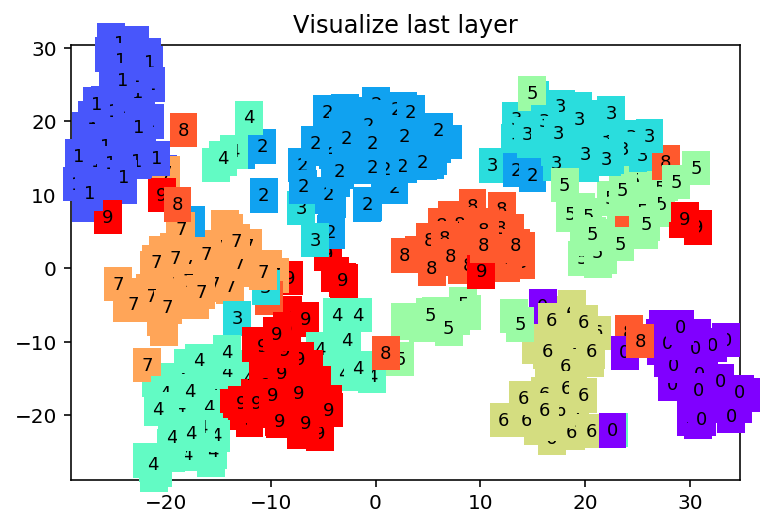

Epoch:  0 | train loss: 0.0247 | test accuracy: 0.97


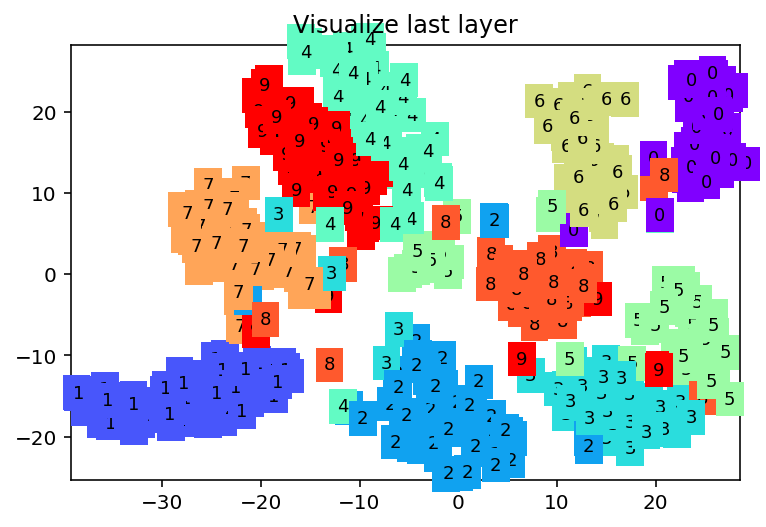

Epoch:  0 | train loss: 0.0570 | test accuracy: 0.97


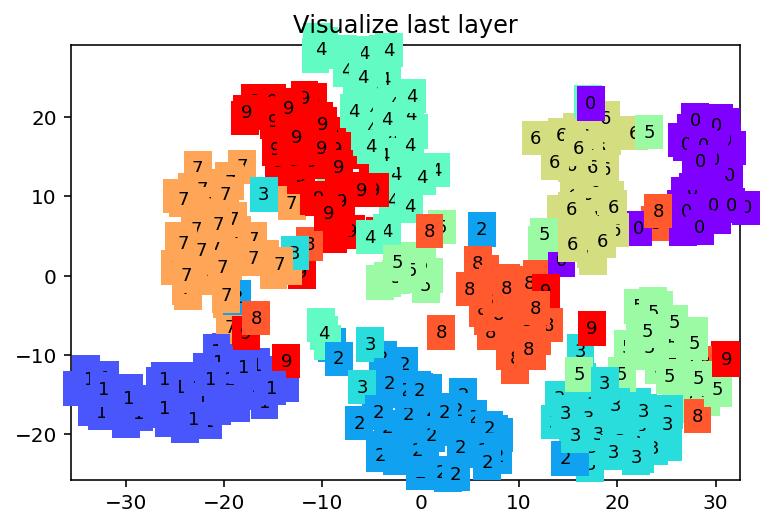

Epoch:  0 | train loss: 0.0700 | test accuracy: 0.97


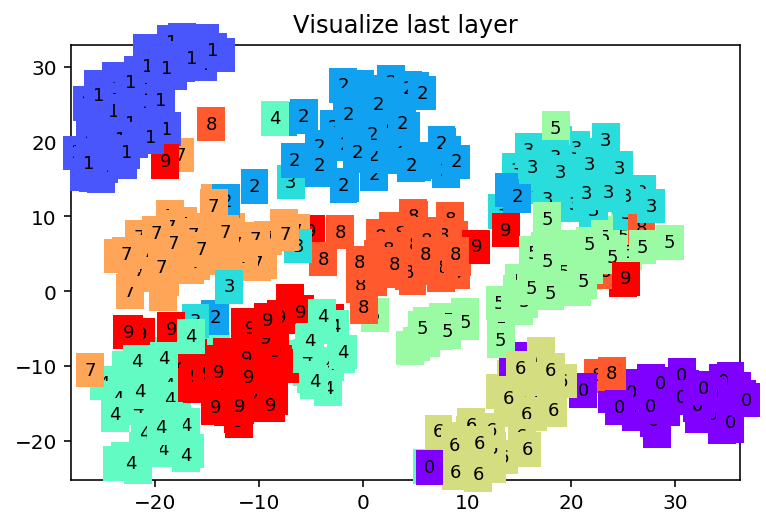

Epoch:  0 | train loss: 0.0903 | test accuracy: 0.98


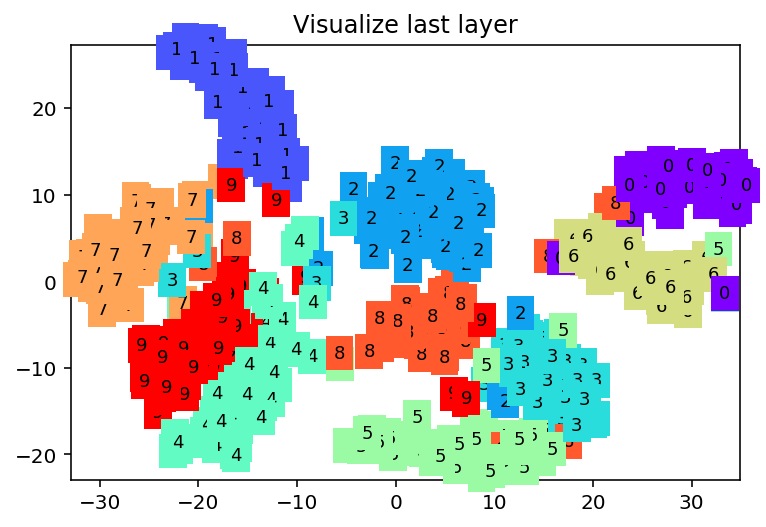

[7 2 1 0 4 1 4 9 5 9] Predition number
[7 2 1 0 4 1 4 9 5 9] real number


In [19]:
plt.ion()
# training and testing
for epoch in range(EPOCHE):
    for step, (b_x, b_y) in enumerate(train_loader):  # gives batch data, normalize x when iterate train_loader
        output = cnn(b_x)[0]        # cnn output 1
        loss=loss_func(output, b_y) # cross entropy loss
        optimizer.zero_grad()       # clear gradients for this training step
        loss.backward()             # backpropagation, compute gradients
        optimizer.step()            # apply gradients
        
        if step%50==0:
            test_output, last_layer=cnn(test_x)
            pred_y=torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne=TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only=500
                low_dim_embs=tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels=test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictioins from the test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'Predition number')
print(test_y[:10].numpy(), 'real number')